In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
import segmentation.src.MapData as mapdata
from sklearn.preprocessing import normalize
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap
import cv2
import mpl_toolkits.axes_grid1
# from scipy import ndimage as ndi
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import hdbscan
# import DBCV.DBCV as DBCV
import plotly.express as px
import os
import mpl_toolkits.axes_grid1
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from numba import njit

# mean absolute deviation for estimating the noise
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='db6', level=2):
    coeff = pywt.wavedec(x, wavelet, mode="reflect", level=4)
    # print(pywt.Wavelet('db1').dec_len)
    sigma = (1/0.6745) * maddest(coeff[-level]) # futher understanding required
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard', substitute=0) for i in coeff[1:])
    return pywt.waverec(coeff, wavelet)


def array_to_vector(
        data: np.array,
        pix_tot: int
    ) -> np.array:
        """Reshapes a spectrum-wise summary statistic (e.g., integrated intensity) into an array with the map's dimensions.

        Args:
            data (np.array): The vector to be reshaped.

        Returns:
            np.array: The input data with the map's dimensions.
        """
        data = data.copy()
        data[::2, :] = data[::2, ::-1]
        data = data.copy().reshape(pix_tot)

        return data

# Create a new directory when it does not exist
def create_dir(dir_name):
    isExist = os.path.exists(dir_name)
    if not isExist:
        os.makedirs(dir_name)
        print("The new directory is created!")

def cluster_by_hdbscan(arr, min_cluster_try):
    hdbmodel = hdbscan.HDBSCAN(min_cluster_size=min_cluster_try, min_samples=min_cluster_try, gen_min_span_tree=True).fit(arr)
    if hdbmodel.labels_.min() == -1:
        k = hdbmodel.labels_.max() + 2
        isnoise = True
    else: 
        k = hdbmodel.labels_.max() + 1
        isnoise = False
    print("min_cluster_size:", min_cluster_try, ", min_samples:", min_cluster_try)
    print("the number of clusters:", k)
    return hdbmodel, k, isnoise


def cluster_by_kmeans(arr, cluster_size):
    kmeansmodel = KMeans(n_clusters=cluster_size, max_iter=100).fit(arr)
    return kmeansmodel.labels_


# plot the data after clustering
def plot_clustered_data(index_vec, cluster_labels, embedding, k, metainfo, dir_name, method, isnoise=False):
    d = {"pos":index_vec,
    "one":embedding[:,0],
    "two":embedding[:,1],
    "three":embedding[:,2]
    }
    df = pd.DataFrame(data=d)
    fig = px.scatter_3d(df, x="one", y="two", z="three",
    color=cluster_labels,
    hover_data=['pos'],
    width=1000, height=800
    )
    fig.write_html("./"+dir_name+"/"+method+"cluster_size="+str(metainfo)+".html")

    fig_result = plt.figure(figsize=(3, 3), dpi = 300)
    ax_result = fig_result.add_subplot(1, 1, 1)
    pic_cluster = md.vector_to_array(cluster_labels)
    if isnoise:
        im = ax_result.imshow(pic_cluster+1, interpolation='none')
    else:
        im = ax_result.imshow(pic_cluster, interpolation='none')
    colors = [ im.cmap(im.norm(value)) for value in range(k)]
    patches = [ mpatches.Patch(color=colors[i], label="cluster {l}".format(l=range(k)[i])) for i in range(k)]
    # put those patched as legend-handles into the legend
    ax_result.legend(handles=patches, bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0. )
    ax_result.set_title("min_cluster_size="+str(metainfo)+", # of cluster="+str(k), fontdict={'fontsize': 7})
    plt.close(fig_result)
    fig_result.savefig("./"+dir_name+"/"+method+"_result"+str(metainfo)+".png", bbox_inches = 'tight')
    del df, d

def normalize_minmax(arr, axis):
    min = arr.min(axis=axis)
    max = arr.max(axis=axis)
    ret = np.zeros(arr.shape)
    ret = (arr - min) / (max - min)
    return ret

def create_mask(arr, thresh, binary_thresh):
    CANNY_LTHRESH = thresh[0]
    CANNY_UTHRESH = thresh[1]
    depth = 2**8
    margin = 10
    brightness = 90
    
    # add margins to the image. This is necessary when dealing with a picture with a cropped sample image.
    output = cv2.copyMakeBorder(arr, margin, margin, margin, margin, cv2.BORDER_CONSTANT, value=brightness)

    # gaussian blur to make the border smoother
    img_blur = cv2.GaussianBlur(output, (11, 11), 9)
    _, thresh = cv2.threshold(img_blur, binary_thresh, depth-1, cv2.THRESH_BINARY)

    # erode, dilate, then erode again. the last erode is necessary for tightly fit the contour 
    kernel = np.ones((5, 5), np.uint8)
    erode = cv2.erode(thresh, kernel, iterations=1)
    dilate = cv2.dilate(erode, kernel, iterations=1)
    erode = cv2.erode(dilate, kernel, iterations=1)

    # find contour that has the maximum length
    canny_edges = cv2.Canny(erode, CANNY_LTHRESH, CANNY_UTHRESH)
    mask=np.zeros(output.shape)
    contours, hierarchy = cv2.findContours(canny_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    length = [cv2.arcLength(contours[i], False) for i in range(len(contours))]
    cnt = contours[np.argmax(length)]
    cv2.drawContours(mask, [cnt], -1, 255, cv2.FILLED)
    cv2.drawContours(output, [cnt], -1, 255, thickness=1)

    # drawing the contour into pictures
    cropped_mask = mask[margin:margin+arr.shape[0],margin:margin+arr.shape[1]]
    cropped_output = output[margin:margin+arr.shape[0],margin:margin+arr.shape[1]]

    cv2.imshow('edge', canny_edges)
    cv2.imshow('erode', erode)
    cv2.imshow('contour', cropped_output)
    cv2.waitKey(0) # waits until a key is pressed
    cv2.destroyAllWindows() # destroys the window showing image
    plt.imshow(cropped_mask)

    return cropped_mask


def draw_mask(arr, pix_tot, wvl_len):
    mask = array_to_vector(arr.astype(bool), pix_tot)
    zero_arr = np.zeros(wvl_len)
    for i in range(pix_tot):
        if not mask[i]:
            md.spectra[i] = zero_arr

def crop_data(arr, crop_length):
    wvl_len = len(arr)
    wvl_idx_from = crop_length
    wvl_idx_to = wvl_len - crop_length - 1
    return np.linspace(start=arr[wvl_idx_from], stop=arr[wvl_idx_to], num=int(2 ** np.ceil(np.log2(len(arr[wvl_idx_from:wvl_idx_to]))))), [wvl_idx_from, wvl_idx_to]


def interpolate_spectra(wvl_croped, crop_idx):
    wvl_idx_from, wvl_idx_to = crop_idx
    # pbar = tqdm(range(md.map_dimensions[0] * md.map_dimensions[1]))
    for i in range(md.map_dimensions[0] * md.map_dimensions[1]):
        # pbar.set_description("Interpolatioin is in progress:")
        md.spectra[i] = np.interp(wvl_croped, md.wvl[wvl_idx_from:wvl_idx_to], md.spectra[i, wvl_idx_from:wvl_idx_to])
    md.wvl = wvl_croped
    

# def similarity(center, surround):
#     N = len(surround)
#     tiled = np.tile(center, (N, 1))
#     return np.sum((surround - tiled)**2)/N

# def find_adjacent(arr, index, max_index):
#     i, j = index
#     imax, jmax = max_index
#     shift = [0, 1, -1]
#     row = [i+k for k in shift if (i+k>=0 and i+k<imax)]
#     column = [j+k for k in shift if (j+k>=0 and j+k<jmax)]
#     ret = []
#     for m in range(len(row)):
#         for n in range(len(column)):
#             if not(m==0 and n==0):
#                 ret.append(arr[row[m], column[n]])
#     return arr[i, j], np.array(ret)

# def pick_adjacent(target_arr, index_arr):
#     ret = []
#     for i in index_arr:
#         ret.append(target_arr[i])
#     return np.array(ret)

# import seaborn as sns
# os.chdir(r"C:/Users/scientist/Desktop/Hiroyuki")

In [2]:
# Triangular kernel from Erik's code
# accerarated by njit

@njit
def get_triangular_kernel(size: int) -> np.array:
    """
    Generates a triangular kernel of a given size.

    Args:
        size (int): an integer representing the size of the kernel.

    Returns:
        np.array: na array representing the triangular kernel.
    """
    return np.concatenate((np.arange(1, size), np.arange(size, 0, -1))) / size

# njit ver
@njit
def triangle_corr(arr: np.array, axis: int = 1) -> np.array:
    """
    Calculates the correlation coefficient of an array with a triangular kernel along a specified axis.

    Args:
        arr (np.array): The input array.
        axis (int, optional):  The axis along which to calculate the correlation. Defaults to 1.

    Returns:
        np.array: The correlation coefficient of the array with the triangular kernel along the specified axis.
    """
    size = np.ceil(arr.shape[1] / 2)
    kernel = get_triangular_kernel(int(size))
    kernel = np.interp(
        np.linspace(0, len(kernel), num=arr.shape[1]),
        np.arange(len(kernel)),
        get_triangular_kernel(size)
    )
    row = arr.shape[0]

    ret = np.zeros(row)

    for i in range(row):
        ret[i] = np.corrcoef(arr[i], kernel)[0, 1]

    return ret


- Load the data
- Resample data. Make the wavelength interval constant
- Denoise and crop
- Don't execute this cell twice

In [3]:
from ipywidgets import IntProgress
from IPython.display import display

md = mapdata.MapData(overwrite=True)
openfile = md.load_all_data("363x202-P49B_II_Avantes_preprocessed")
md.get_metadata()
md.get_map_dimensions()
md.create_data_type()
md.load_wavelenths()
pix_tot = md.map_dimensions[0] * md.map_dimensions[1]
md.upsample_spectra()

crop_length = 50 
wvl_croped, crop_idx = crop_data(md.wvl, crop_length)
interpolate_spectra(wvl_croped, crop_idx)
del(wvl_croped)

# Denoise by wavelet decomposition
# Can make as a function
pbar = tqdm(range(pix_tot))
for i in pbar:
    pbar.set_description("Denoising...")
    md.spectra[i] = denoise(md.spectra[i])

md.get_baseline()
md.baseline_correct()
wvl_len = md.wvl.shape

preprocessed file was not found; setting overwrite to True
loading raw data
loading metadata
loading metadata
getting map dimensions
loading wavelengths
upsampling spectra


  0%|          | 0/73326 [00:00<?, ?it/s]

getting baselines


- Find peaks from the maximum spectrum
- Get the intensity value at each peak

  0%|          | 0/21 [00:00<?, ?it/s]

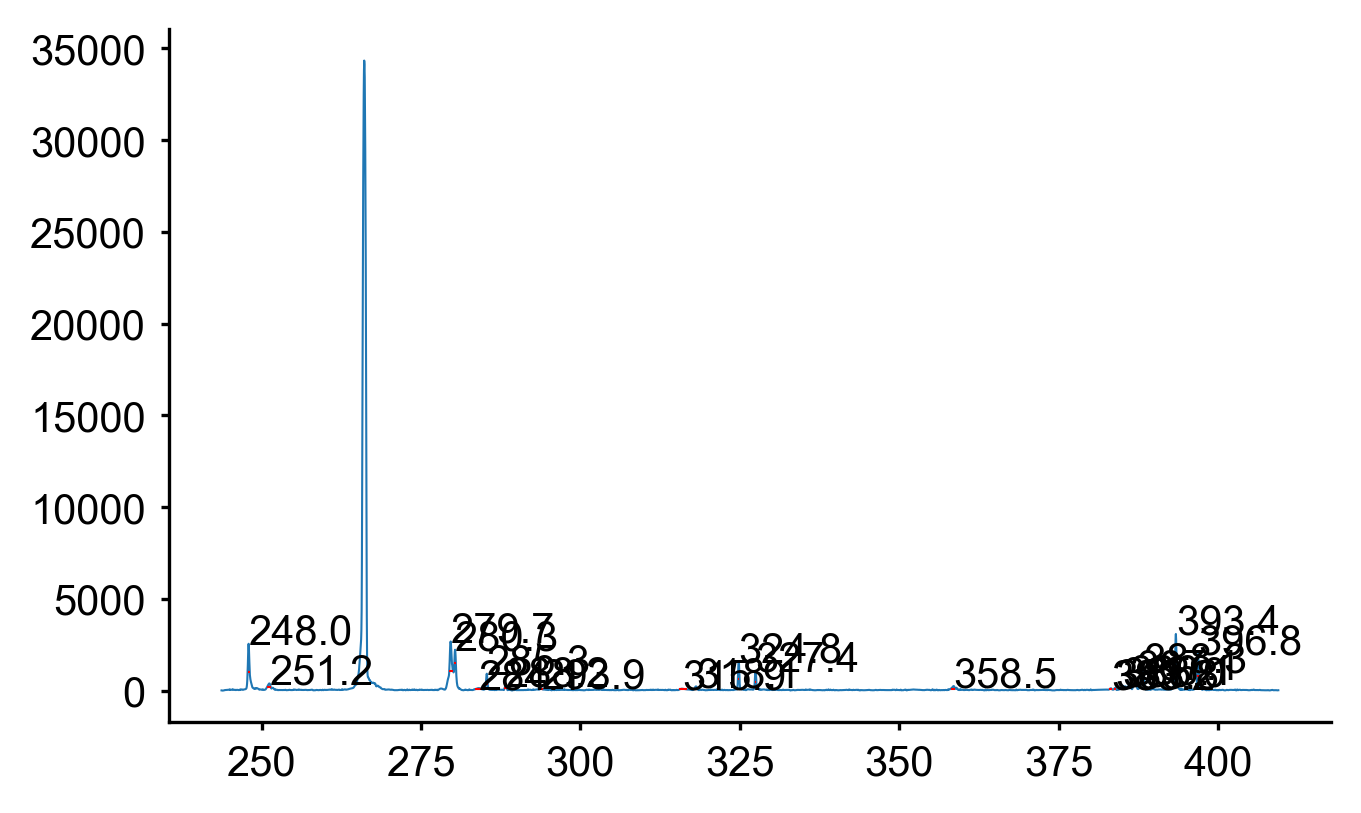

In [4]:
# intensities is defined by the correlation coefficient between a triangle and a rawdata
# For finding peaks among the maximum spectrum

plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.direction"] = 'out'
plt.rcParams["ytick.direction"] = 'out'
plt.rcParams["lines.linewidth"] = 0.5


th_prominence = 70 # detect emission lines above this threshold
maxspectrum = md.spectra.max(axis=0)
peaks, _ = find_peaks(maxspectrum, height=[0, 20000], prominence=th_prominence)
results_full = peak_widths(maxspectrum, peaks, rel_height=0.6)

# map each peak on a figure
fig = plt.figure(figsize=(5, 3), dpi = 300)
ax = fig.add_subplot(1, 1, 1)
ax.plot(md.wvl, maxspectrum)
for i in range(len(peaks)):
    ax.hlines(results_full[1][i], md.wvl[int(results_full[2][i])], md.wvl[int(results_full[3][i])], color = "red")
    ax.text(md.wvl[peaks[i]], maxspectrum[peaks[i]], "%.1f" %md.wvl[peaks[i]])
    # ax.text(maxspectrum[peaks[i]], "%.1f" %md.wvl[peaks[i]])
    maxprofile = pd.Series(maxspectrum[peaks], dtype=float)

array2 = np.zeros((pix_tot, len(peaks)))
pbar = tqdm(range(len(peaks)))
for i in pbar:
    pbar.set_description("Calculating correlation coefficients:")
    array2[:, i] = triangle_corr(md.spectra[:, int(np.ceil(results_full[-2][i])):int(np.ceil(results_full[-1][i]))])

pic_arr = np.array([md.vector_to_array(i) for i in array2.T])

# create a directry to save the intensity pictures
dir_name = 'figure_correlation_P24B_db4level2_minsample_50_100_150_200_min_cluster_size_1000'
isExist = os.path.exists(dir_name)
if not isExist:
   os.makedirs(dir_name) # Create a new directory when it does not exist
   print("A new directory is created!")

# save the intensity pictures. not to be displayed
for i in range(len(peaks)):
    fig = plt.figure(figsize=(5, 3), dpi = 300)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(r"$\lambda = $ %.2f" %md.wvl[peaks[i]], size = 10)
    divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes('right', '5%', pad='3%')
    im = ax.imshow(pic_arr[i], interpolation='none')
    fig.colorbar(im, cax=cax)
    plt.close(fig)
    fig.savefig("./"+dir_name+"/fig"+str(i)+".png", bbox_inches="tight")
    del fig, ax


- create a mask of the sample and remove the background

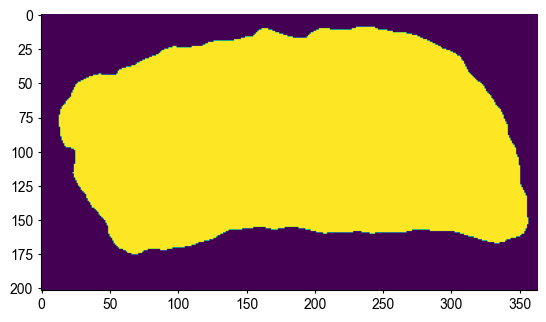

In [5]:
# mask the sample region

def create_mask(arr, thresh, binary_thresh):
    CANNY_LTHRESH = thresh[0]
    CANNY_UTHRESH = thresh[1]
    depth = 2**8
    margin = 10
    brightness = 90
    
    # add margins to the image. This is necessary when dealing with a picture with a cropped sample image.
    output = cv2.copyMakeBorder(arr, margin, margin, margin, margin, cv2.BORDER_CONSTANT, value=brightness)

    # gaussian blur to make the border smoother
    img_blur = cv2.GaussianBlur(output, (11, 11), 9)
    _, thresh = cv2.threshold(img_blur, binary_thresh, depth-1, cv2.THRESH_BINARY)

    kernel = np.ones((7, 7), np.uint8)
    dilate = cv2.dilate(thresh, kernel, iterations=1)
    kernel = np.ones((5, 5), np.uint8)
    erode = cv2.erode(dilate, kernel, iterations=1)
    kernel = np.ones((3, 3), np.uint8)
    erode = cv2.erode(erode, kernel, iterations=1)

    # find contour that has the maximum length
    canny_edges = cv2.Canny(erode, CANNY_LTHRESH, CANNY_UTHRESH)
    mask=np.zeros(output.shape)
    contours, hierarchy = cv2.findContours(canny_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    length = [cv2.arcLength(contours[i], False) for i in range(len(contours))]
    cnt = contours[np.argmax(length)]
    cv2.drawContours(mask, [cnt], -1, 255, cv2.FILLED)
    cv2.drawContours(output, [cnt], -1, 255, cv2.FILLED)

    # drawing the contour into pictures
    cropped_mask = mask[margin:margin+arr.shape[0],margin:margin+arr.shape[1]]
    cropped_output = output[margin:margin+arr.shape[0],margin:margin+arr.shape[1]]

    cv2.imshow('edge', canny_edges)
    cv2.imshow('erode', erode)
    cv2.imshow('contour', output)
    cv2.waitKey(0) # waits until a key is pressed
    cv2.destroyAllWindows() # destroys the window showing image
    plt.imshow(cropped_mask)

    return cropped_mask

wvl_len = md.wvl.shape
focus_idx = 20 # the index for the specific spectra
thresh = [0, 0]
binary_thresh = 140
gray_arr = np.uint8(md.vector_to_array(255*normalize_minmax(array2[:, focus_idx], axis=None)))
mask = create_mask(gray_arr, thresh, binary_thresh)
# draw_mask(mask, pix_tot, wvl_len)

- data reconstitution. omit the uninfromative spectra.
- crop data around each peak and concatanate them.
- normalization or scaling of the data

In [6]:
# del spectrum_norm

pix_window = 7
peaks_focus = [2, 3, 8, 9, 19, 20]
# wvl_after = np.ravel(np.array([md.wvl[peaks[i]-pix_window:peaks[i]+pix_window+1] for i in peaks_focus]))

# crop data
wvl_after = np.ravel(np.array([md.wvl[peaks[i]-pix_window:peaks[i]+pix_window+1] for i in peaks_focus]))
spectrum_after = np.array([np.ravel([md.spectra[i, peaks[j]-pix_window:peaks[j]+pix_window+1] for j in peaks_focus]) for i in range(pix_tot)])

# normalization by min-max method. min and max value is from whole data regardless of the feature.
spectrum_norm = normalize_minmax(spectrum_after, axis=0)

# standard scaling
# spectrum_scaled = StandardScaler().fit_transform(spectrum_after)

# print(spectrum_after.shape)

- Dimension reduction by a certain algorithm
- I've only tried UMAP and PCA during my stay.
- other manifold learning could be used.
- try several hyper parameters to do the grid search in the later process.

In [7]:
n_neighbors_try = [5, 10, 15, 20, 50]
# min_cluster_size_try = [40, 60, 80, 100, 120, 140, 160, 180, 200]
n_components = 2

embedding_norm = []
embedding_scaled = []

labels_norm = []
labels_scaled = []

# save all of the embeddings that are tried
pbar = tqdm(n_neighbors_try)
for i in pbar:
    pbar.set_description("UMAP embedding is ongoing:")
    reducer = umap.UMAP(n_neighbors=i, metric="cosine", min_dist = 0.1, n_components=n_components)
    embedding_norm.append(reducer.fit_transform(spectrum_norm))
    # embedding_scaled.append(reducer.fit_transform(spectrum_scaled))

del spectrum_norm

  0%|          | 0/5 [00:00<?, ?it/s]

- HDBSCAN
- find the optimal hyper parameters by grid search

In [8]:
# HDBSCAN part
# scoring = dbcv_relative

def cluster_by_hdbscan(arr, min_cluster_try, min_samples):
    hdbmodel = hdbscan.HDBSCAN(min_cluster_size=min_cluster_try, min_samples=min_samples, gen_min_span_tree=True).fit(arr)
    if hdbmodel.labels_.min() == -1:
        csize = hdbmodel.labels_.max() + 2
        isnoise = True
    else: 
        csize = hdbmodel.labels_.max() + 1
        isnoise = False
    # print("min_cluster_size:", min_cluster_try, ", min_samples:", min_cluster_try)
    # print("the number of clusters:", k)
    return hdbmodel, csize, isnoise

# function that have finite value between lth and uth. for adjusting cluster size
def step(x, lth, uth):
    if lth <= x and x <= uth:
        return 1
    else:
        return 0

# del pic_arr, array2
min_cluster_size_try = [100,]
min_sample_try = [50, 100, 200, 500, 1000]
score_norm = np.zeros((len(n_neighbors_try), len(min_sample_try)))
lth = 3
uth = 8

# try HDBscan for all of the data
pbar = tqdm(range(len(n_neighbors_try)))


for i in pbar:
    pbar.set_description("HDBSCAN:")
    for j in range(len(min_sample_try)):
    # for normalized data
        hdbmodel, csize, _ = cluster_by_hdbscan(embedding_norm[i], min_cluster_size_try[0], min_sample_try[j])
        clust_size_eval = step(csize, lth, uth)
        if clust_size_eval != 0:
            score_norm[i, j] = hdbmodel.relative_validity_ * clust_size_eval * hdbmodel.cluster_persistence_.min()
    # for scaled data
    # hdbmodel, clustersize_scaled[i, j], _ = cluster_by_hdbscan(embedding_scaled[i], min_cluster_size_try[j])
    # score_scaled[i, j] = hdbmodel.relative_validity_


  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
# for visualization. instant code

# fig1 = plt.figure(figsize=(5,8), dpi = 300)
# ax11 = fig1.add_subplot(1, 1, 1)
# ax12 = fig1.add_subplot(2, 1, 2)

# fig2 = plt.figure(figsize=(5,8), dpi = 300)
# ax21 = fig2.add_subplot(2, 1, 1)
# ax22 = fig2.add_subplot(2, 1, 2)

# im11 = ax11.imshow(score_norm)
# fig1.colorbar(im11)

a, b = np.unravel_index(score_norm.argmax(), score_norm.shape)
print([a, b])
# im12 = ax12.imshow(clustersize_norm)
# fig1.colorbar(im12)

# im21 = ax21.imshow(score_scaled)
# fig2.colorbar(im21)
# im22 = ax22.imshow(clustersize_scaled)
# fig2.colorbar(im22)


[1, 4]


- Plot

In [11]:
# plot the data after clustering
def plot_clustered_data(index_vec, cluster_labels, embedding, k, metainfo, dir_name, method, isnoise=False):
    plt.rcParams['xtick.minor.size'] = 0
    plt.rcParams['ytick.minor.size'] = 0
    plt.rcParams['xtick.major.size'] = 7
    plt.rcParams['ytick.major.size'] = 7
    plt.rcParams['xtick.major.width'] = 6
    plt.rcParams['ytick.major.width'] = 6
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["axes.spines.right"] = True
    plt.rcParams["axes.spines.top"] = True
    plt.rcParams["axes.linewidth"] = 2
    plt.rcParams["lines.linewidth"]= 1
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams["xtick.minor.bottom"] = True
    
    isExist = os.path.exists(dir_name)
    if not isExist:
       os.makedirs(dir_name) # Create a new directory when it does not exist
       print("The new directory is created!")

    ticks_size = 14
    ticks_width = 1
    marker_size = 1
    font_size = 18
    x_tick_num = [-30, -20, -10, 0, 10, 20, 30]
    y_tick_num = [-20, -10, 0, 10, 20]


    d = {"pos":index_vec,
    "one":embedding[:,0],
    "two":embedding[:,1],
    # "three":embedding[:,2]
    }
    df = pd.DataFrame(data=d)
    fig_emb = plt.figure(figsize=(5, 5), dpi=300)
    ax_emb = fig_emb.add_subplot(1, 1, 1)
    ax_emb.scatter(embedding[:,0], embedding[:,1], #x="one", y="two", z="three",
    c=cluster_labels,
    s=2
    )
    # ax_emb.axis('off')
    ax_emb.tick_params(axis = 'x', labelsize = ticks_size, width = ticks_width)
    ax_emb.tick_params(axis = 'y' , labelsize = ticks_size, width = ticks_width)
    ax_emb.set_xticks(x_tick_num)
    ax_emb.set_yticks(y_tick_num)
    ax_emb.set_xlabel(r"$Y_1$", size=font_size)
    ax_emb.set_ylabel(r"$Y_2$", size=font_size)
    plt.close(fig_emb)
    fig_emb.savefig("./"+dir_name+"/"+method+"cluster_size="+str(metainfo)+"_demo.png", bbox_inches="tight")

    fig_result = plt.figure(figsize=(3, 3), dpi = 300)
    ax_result = fig_result.add_subplot(1, 1, 1)
    ax_result.axis('off')
    pic_cluster = md.vector_to_array(cluster_labels)
    if isnoise:
        im = ax_result.imshow(pic_cluster+1, interpolation='none')
    else:
        im = ax_result.imshow(pic_cluster, interpolation='none')
    colors = [ im.cmap(im.norm(value)) for value in range(k)]
    patches = [ mpatches.Patch(color=colors[i], label="cluster {l}".format(l=range(k)[i])) for i in range(k)]
    # put those patched as legend-handles into the legend
    ax_result.legend(handles=patches, bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0., frameon=False)
    ax_result.set_title("min_cluster_size="+str(metainfo)+", # of cluster="+str(k), fontdict={'fontsize': 7})
    plt.close(fig_result)
    fig_result.savefig("./"+dir_name+"/"+method+"_result"+str(metainfo)+".png", bbox_inches = 'tight')
    del df, d


hdbmodel, csize, isnoise = cluster_by_hdbscan(embedding_norm[a], min_cluster_size_try[0], min_sample_try[b])
plot_clustered_data(range(pix_tot), hdbmodel.labels_,embedding_norm[0], csize, min_cluster_size_try[0], "P49B", "hdbscan", isnoise=isnoise)
# score_norm[i, j] = hdbmodel.relative_validity_

-other score function: silhouette score

In [ ]:
# HDBSCAN part
# scoreing = silhouette
# theoretically not applicable to any density based clustering methods. This is just for testing.
from sklearn.metrics import silhouette_score

def step(x, lth, uth):
    if lth <= x and x <= uth:
        return 1
    else:
        return 0

min_cluster_size_try = [40, 60, 80, 100, 120, 140, 160, 180, 200]
lth = 4
uth = 7

# try HDBscan for all of the data
pbar = tqdm(range(len(n_neighbors_try)))
for i in pbar:
    pbar.set_description("HDBSCAN:")
    for j in range(len(min_cluster_size_try)):
        # for normalized data
        hdbmodel, k, _ = cluster_by_hdbscan(embedding_norm[i], min_cluster_size_try[j])
        clust_size_eval = step(k, lth, uth)
        if clust_size_eval != 0:
            score_norm[i, j] = silhouette_score(embedding_norm[i], hdbmodel.labels_) * clust_size_eval
        # for scaled data
        # hdbmodel, clustersize_scaled[i, j], _ = cluster_by_hdbscan(embedding_scaled[i], min_cluster_size_try[j])
        # score_scaled[i, j] = hdbmodel.relative_validity_

In [ ]:
# HDBSCAN part
# scoring = dbcv
# too much time required

import DBCV.DBCV as DBCV
# from numba import jit

# @jit
def step(x, lth, uth):
    if lth <= x and x <= uth:
        return 1
    else:
        return 0

min_cluster_size_try = [50, 75, 100, 125, 150, 175, 200]
lth = 4
uth = 7

# try HDBscan for all of the data
pbar = tqdm(range(len(n_neighbors_try)))
for i in pbar:
    pbar.set_description("HDBSCAN:")
    for j in range(len(min_cluster_size_try)):
        # for normalized data
        hdbmodel, k, _ = cluster_by_hdbscan(embedding_norm[i], min_cluster_size_try[j])
        clust_size_eval = step(k, lth, uth)
        if clust_size_eval != 0:
            score_norm[i, j] = DBCV.DBCV(embedding_norm[i], hdbmodel.labels_)*clust_size_eval
        # for scaled data
        # hdbmodel, clustersize_scaled[i, j], _ = cluster_by_hdbscan(embedding_scaled[i], min_cluster_size_try[j])
        # score_scaled[i, j] = DBCV(embedding_norm[i], hdbmodel.labels_)